In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

import pyfrac
from pyfrac.utils.sofiutils import *
from pyfrac.utils.modellingutils import *
from pyfrac.hydrafrac.acquisition import recgeom,recgeom_rockblock

In [2]:
data_dir = '/home/birniece/Documents/data/ANPERC_Lab/LargeRockBlock/Sandstone'

# Rock Properties - subsurface models

In [3]:
modname = 'expSetUp_wBounds'


In [4]:
rock_dims = 0.4
rubber_dims = 0.02

dimlims = np.round(rock_dims, decimals=2)
dx = dy = dz = 0.001  # 2mm
nabs = 32  # number of points absorbing boundary
nx = ny = nz = int(dimlims/dx)

# Accounting for media that ain't the rock
r_shift = (nabs + (rubber_dims/dx)) *dx
s_shift = nabs/dx + (rubber_dims/dx)
print(r_shift)

0.052000000000000005


In [5]:
r_shift


0.052000000000000005

In [6]:
rock_vp = 5260  # m/s
rock_vs = 3260  # m/s
rock_rho = 2590;  # kg/m3

rubber_vp = 300 # m/s after eq 4 of https://www.sciencedirect.com/science/article/pii/S2588840420300445#fig5
rubber_vs = (2/3) * rubber_vp  # 2/3 of vp
rubber_rho = 1000 ;  # kg/m3

steel_vp = 6030  # m/s
steel_vs = 3260  # m/s
steel_rho = 2667;  # kg/m3

In [7]:
vp_mod, vs_mod, rho_mod = make_homo_model(dimlims,
                                            dx,
                                            [steel_vp, steel_vs, steel_rho],
                                            pad=True,
                                            npad=nabs+(rubber_dims/dx) ,
                                            freesurface=True
                                            )

In [8]:
vp_mod.shape

(504, 452, 504)

In [9]:
0.4/dx

400.0

In [10]:
r_shift/dx

52.0

In [11]:
absplusrub = nabs + int(rubber_dims/dx)

vp_mod[nabs:-nabs,:-nabs,nabs:-nabs] = rubber_vp
vs_mod[nabs:-nabs,:-nabs,nabs:-nabs] = rubber_vs
rho_mod[nabs:-nabs,:-nabs,nabs:-nabs] = rubber_rho

vp_mod[absplusrub:-(absplusrub-1),:-(absplusrub-1),absplusrub:-(absplusrub-1)] = rock_vp
vs_mod[absplusrub:-(absplusrub-1),:-(absplusrub-1),absplusrub:-(absplusrub-1)] = rock_vs
rho_mod[absplusrub:-(absplusrub-1),:-(absplusrub-1),absplusrub:-(absplusrub-1)] = rock_rho

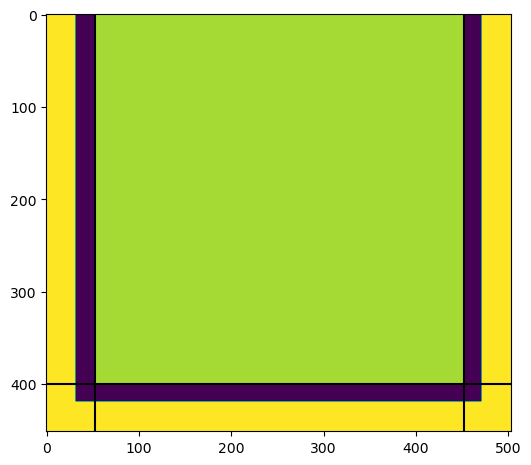

In [12]:
fig,ax = plt.subplots(1,1,figsize=[6,6])
ax.imshow(vp_mod[nx//2,:,:])
ax.axvline(r_shift/dx,c='k')
ax.axvline(r_shift/dx+rock_dims/dx,c='k')
ax.axhline(rock_dims/dx,c='k')

In [13]:
vp_mod.transpose([0,2,1]).astype(np.float32).tofile(os.path.join(data_dir,'%s_xyz_1mm.vp'%modname))#,format='<f')
vs_mod.transpose([0,2,1]).astype(np.float32).tofile(os.path.join(data_dir,'%s_xyz_1mm.vs'%modname))  #,format='<f')
rho_mod.transpose([0,2,1]).astype(np.float32).tofile(os.path.join(data_dir,'%s_xyz_1mm.rho'%modname))  #,format='<f')

# Acquisition Geometry - Receivers & Source

## RECEIVERS

In [14]:
r_shift

0.052000000000000005

In [15]:
# RECEIVERS
nrperface = 39

# don't need to change below
r_nxyz = [40, 40, 40]
r_dxyz = [0.01, 0.01, 0.01]
gridded_recs, nr, rec_string = recgeom(r_nxyz, 
                                       r_dxyz, 
                                       nrperfc_xyz=[nrperface], 
                                       recbuf_gps=1,
                                       sofishift=0)

# Shift in x and y
gridded_recs[0] = gridded_recs[0] + r_shift
gridded_recs[1] = gridded_recs[1] + r_shift
print (nr, gridded_recs.shape)
print(gridded_recs)

gridded_recs = np.array([gridded_recs[0], gridded_recs[2], gridded_recs[1], ])
print (nr, gridded_recs.shape)
print(gridded_recs)

9126 (3, 9126)
[[0.052 0.052 0.052 ... 0.422 0.432 0.442]
 [0.062 0.062 0.062 ... 0.442 0.442 0.442]
 [0.01  0.02  0.03  ... 0.4   0.4   0.4  ]]
9126 (3, 9126)
[[0.052 0.052 0.052 ... 0.422 0.432 0.442]
 [0.01  0.02  0.03  ... 0.4   0.4   0.4  ]
 [0.062 0.062 0.062 ... 0.442 0.442 0.442]]


In [16]:
dx

0.001

Text(0.5, 1.0, 'Experimental SetUp')

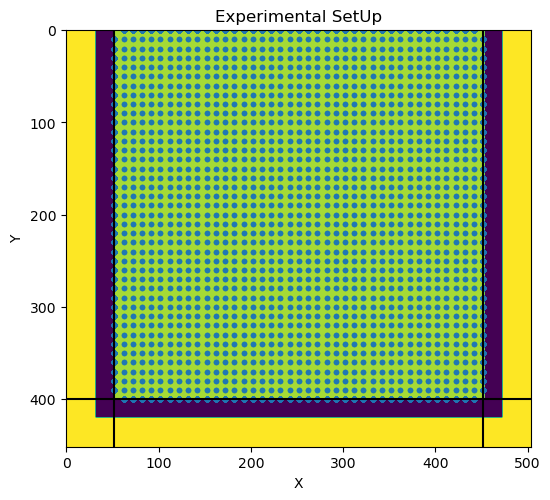

In [17]:
fig,ax = plt.subplots(1,1,figsize=[6,6])
ax.imshow(vp_mod[nx//2,:,:])
ax.scatter(gridded_recs[2]/dx, gridded_recs[1]/dx,marker='.')
ax.axvline(r_shift/dx,c='k')
ax.axvline(r_shift/dx+rock_dims/dx,c='k')
ax.axhline(rock_dims/dx,c='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Experimental SetUp')

In [18]:
np.savetxt(os.path.join(data_dir,'RecArray_%s_1mm.dat'%modname),
           gridded_recs.T.astype(np.float32), 
           fmt='%.2f')

## SOURCES 

In [19]:
fc_kHz = 25  # kHz
fs_kHz = 100

fc = fc_kHz * 1000
fs = fs_kHz * 1000
rec_dt = 1/fs

amp = 1.  # amplitude

print(f"Event Central Frequency: {fc},\nSampling Frequency: {fs},\nReceiver dt: {rec_dt}")

Event Central Frequency: 25000,
Sampling Frequency: 100000,
Receiver dt: 1e-05


In [20]:
# MAKE STRINGS PER SHOT LOC
sz = 0.2 
sy = np.round(vp_mod.shape[2]//2 *dx, decimals=2)
sx = np.round(vp_mod.shape[0]//2 *dx, decimals=2)

td = 1/fs  # ignition time

string_list = [str(i) for i in [sx, sz, sy, td, fc, amp]]

# Save to file
src_filename = 'SourceArray_singleshots_%s_1mm.dat'%modname

# print(src_filename)
src_file = os.path.join(data_dir,src_filename)  
# print(src_file)  
text_file = open(src_file, "wt")
text_file.writelines('\t'.join(string_list))
text_file.close()

In [21]:
string_list

['0.25', '0.2', '0.25', '1e-05', '25000', '1.0']

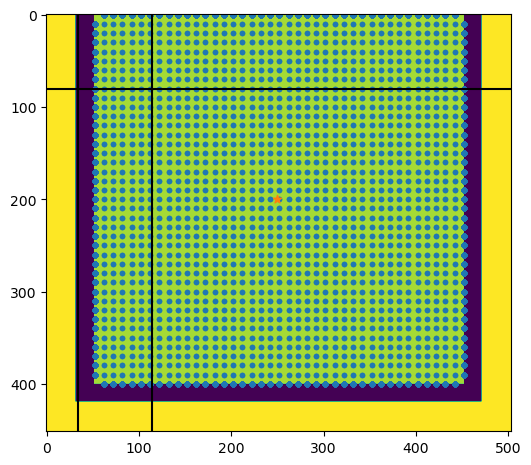

In [22]:
fig,ax = plt.subplots(1,1,figsize=[6,6])
ax.imshow(vp_mod[nx//2,:,:])
ax.scatter(gridded_recs[2]/dx, gridded_recs[1]/dx,marker='.')
ax.scatter(sy/dx, sz/dx,marker='*')
ax.axvline(34,c='k')
ax.axvline(34+80,c='k')
ax.axhline(80,c='k')

In [23]:
vp_mod.shape

(504, 452, 504)